In [1]:
import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile

%matplotlib inline

In [2]:
# Load preprocessed training examples
X = np.load("./ml/train/X.npy")
Y = np.load("./ml/train/Y.npy")

In [3]:
X.shape, Y.shape

((1000, 11998, 101), (1000, 2996, 1))

In [4]:
# Load preprocessed training examples
X_test = np.load("./ml/test/X.npy")
Y_test = np.load("./ml/test/Y.npy")

In [5]:
X_test.shape, Y_test.shape

((100, 11998, 101), (100, 2996, 1))

In [6]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam

Using TensorFlow backend.


In [13]:
# GRADED FUNCTION: model

def model(input_shape):
    """
    Function creating the model's graph in Keras.
    
    Argument:
    input_shape -- shape of the model's input data (using Keras conventions)

    Returns:
    model -- Keras model instance
    """
    
    X_input = Input(shape = input_shape)
    
    ### START CODE HERE ###
    
    # Step 1: CONV layer (≈4 lines)
    X = Conv1D(196, kernel_size=15, strides=4)(X_input)                                 # CONV1D
    X = BatchNormalization()(X)                                 # Batch normalization
    X = Activation('relu')(X)                                 # ReLu activation
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)

    # Step 2: First GRU Layer (≈4 lines)
    X = GRU(units = 128, return_sequences = True)(X) # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)
    X = BatchNormalization()(X)                                 # Batch normalization
    
    # Step 3: Second GRU Layer (≈4 lines)
    X = GRU(units = 128, return_sequences = True)(X)   # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)
    X = BatchNormalization()(X)                                  # Batch normalization
    X = Dropout(0.8)(X)                                  # dropout (use 0.8)
    
    # Step 4: Time-distributed dense layer (≈1 line)
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X) # time distributed  (sigmoid)

    ### END CODE HERE ###

    model = Model(inputs = X_input, outputs = X)
    
    return model  

In [14]:
Tx = 11998 # The number of time steps input to the model from the spectrogram
n_freq = 101 # Number of frequencies input to the model at each time step of the spectrogram
Ty = 2996 # The number of time steps in the output of our model

In [15]:
model = model(input_shape = (Tx, n_freq))

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 11998, 101)        0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2996, 196)         297136    
_________________________________________________________________
batch_normalization_4 (Batch (None, 2996, 196)         784       
_________________________________________________________________
activation_2 (Activation)    (None, 2996, 196)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 2996, 196)         0         
_________________________________________________________________
gru_3 (GRU)                  (None, 2996, 128)         124800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 2996, 128)         0         
__________

In [17]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [18]:
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[f1])

In [19]:
model.fit(X, Y, batch_size = 50, epochs=100, 
              callbacks=[EarlyStopping()],
              validation_data=(X_test, Y_test)
          )

Train on 1000 samples, validate on 100 samples
Epoch 1/100


KeyboardInterrupt: 

In [16]:
loss, acc = model.evaluate(X_test, Y_test)
print("Test set accuracy = ", acc)

ValueError: Error when checking input: expected input_1 to have shape (5511, 101) but got array with shape (11998, 101)

In [17]:
def detect_triggerword(filename):
    plt.subplot(2, 1, 1)

    x, data, rate, times = graph_spectrogram(filename)
    print(get_wav_info(filename))
    # the spectogram outputs (freqs, Tx) and we want (Tx, freqs) to input into the model
    x  = x.swapaxes(0,1)
    x = np.expand_dims(x, axis=0)
    print(len(x), len(x[0]))
    print(x[0])
    predictions = model.predict(x)
    
    plt.subplot(2, 1, 2)
    plt.plot(predictions[0,:,0])
    print(predictions[0,:,0])
    plt.ylabel('probability')
    plt.show()
    return predictions

./ml/generated/train800.wav


NameError: name 'graph_spectrogram' is not defined

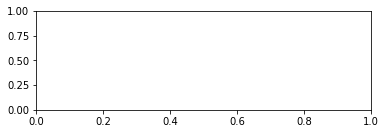

In [18]:
filename_t = "./ml/generated/train{0}.wav"
i = 800
while True:
    try:
        filename = filename_t.format(i)
        print(filename)
        prediction = detect_triggerword(filename)
        break
    except ValueError:
        i += 1
        continue

IPython.display.Audio(filename)

In [48]:
model.save('1_model.h5')